### Summary
This notebook uses the data stored in `dev.bi.s12n_partner_average_annual_b2c_revenue_mgtv` and leverages the annual average B2C revenue by partner and clusters them. These clusters are then ranked based on their mean values and then these ranks are provided as input to the s12n forecasting model.

The idea is that these cluster ranks will capture the partner "fixed effect" -- i.e. the partner brand impact on the annual B2C revenue collected by s12n title on the Coursera platform.

An earlier version of this approach looked at the average revenue by s12n and partner, but this was resulting in biasing results towards those partners that launched 1 s12n/cert which was very successful (i.e. Intuit)

In [0]:
%pip install kneed
%pip install threadpoolctl==2.1.0

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from kneed import KneeLocator
import warnings
import matplotlib.pyplot as plt
import os
warnings.filterwarnings('ignore')

# Suppress warnings globally
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Limit thread usage
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"


In [0]:
def find_optimal_clusters(X, max_clusters=10):
    """
    Determines optimal number of clusters using multiple methods
    
    Parameters:
    X: scaled data
    max_clusters: maximum number of clusters to consider
    """
    
    # Store metrics
    inertias = []
    silhouette_scores = []
    ch_scores = []
    
    # Calculate metrics for different numbers of clusters
    K = range(2, max_clusters + 1)
    for k in K:
        # KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        
        # Calculate metrics
        inertias.append(kmeans.inertia_)
        sil_score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(sil_score)
        ch_score = calinski_harabasz_score(X, kmeans.labels_)
        ch_scores.append(ch_score)
    
    # Elbow method using KneeLocator
    kn = KneeLocator(K, inertias, curve='convex', direction='decreasing')
    elbow_k = kn.knee
    
    # Silhouette method
    silhouette_k = K[np.argmax(silhouette_scores)]
    
    # Calinski-Harabasz method
    ch_k = K[np.argmax(ch_scores)]
    
    # Calculate the final optimal k as the mode of the three methods
    optimal_k = int(np.median([elbow_k, silhouette_k, ch_k]))
    
    return optimal_k, (inertias, silhouette_scores, ch_scores, K)

def plot_cluster_metrics(metrics, optimal_k):
    """
    Plots the metrics used to determine optimal number of clusters
    """
    inertias, silhouette_scores, ch_scores, K = metrics
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Elbow plot
    ax1.plot(K, inertias, 'bx-')
    ax1.axvline(x=optimal_k, color='r', linestyle='--')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')
    
    # Silhouette score plot
    ax2.plot(K, silhouette_scores, 'bx-')
    ax2.axvline(x=optimal_k, color='r', linestyle='--')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Method')
    
    # Calinski-Harabasz score plot
    ax3.plot(K, ch_scores, 'bx-')
    ax3.axvline(x=optimal_k, color='r', linestyle='--')
    ax3.set_xlabel('k')
    ax3.set_ylabel('Calinski-Harabasz Score')
    ax3.set_title('Calinski-Harabasz Method')
    
    plt.tight_layout()
    plt.show()

def cluster_and_rank(df, method='kmeans', eps=0.5, min_samples=5):
    """
    Performs clustering and ranks clusters based on their means
    """
    
    # Prepare data for clustering
    X = df['avg_yearly_revenue_across_s12ns'].values.reshape(-1, 1)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters for KMeans and GMM
    if method.lower() in ['kmeans', 'gmm']:
        optimal_k, metrics = find_optimal_clusters(X_scaled)
        plot_cluster_metrics(metrics, optimal_k)
        print(f"Optimal number of clusters: {optimal_k}")
    
    # Perform clustering based on selected method
    if method.lower() == 'kmeans':
        clusterer = KMeans(n_clusters=optimal_k, random_state=42)
        cluster_labels = clusterer.fit_predict(X_scaled)
        
    elif method.lower() == 'dbscan':
        # For DBSCAN, we'll use the original parameters as it doesn't require n_clusters
        clusterer = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = clusterer.fit_predict(X_scaled)
        
    elif method.lower() == 'gmm':
        clusterer = GaussianMixture(n_components=optimal_k, random_state=42)
        cluster_labels = clusterer.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Calculate cluster means and rank them
    cluster_means = df_clustered.groupby('cluster')['avg_yearly_revenue_across_s12ns'].mean()
    cluster_ranks = cluster_means.rank(ascending=False)
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'cluster': cluster_means.index,
        'mean_revenue': cluster_means.values,
        'rank': cluster_ranks.values,
        'size': df_clustered.groupby('cluster').size().values
    })
    summary_df = summary_df.sort_values('rank')
    
    return df_clustered, summary_df

def plot_clusters(df_clustered, method):
    plt.figure(figsize=(10, 6))
    
    # Create scatter plot
    scatter = plt.scatter(range(len(df_clustered)), 
                         df_clustered['avg_yearly_revenue_across_s12ns'],
                         c=df_clustered['cluster'], 
                         cmap='viridis')
    
    plt.title(f'Clusters using {method.upper()}')
    plt.xlabel('Index')
    plt.ylabel('Average Yearly Revenue')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

def create_partner_rank_table(df_clustered, summary_df):
    """
    Creates a table mapping partner IDs to their cluster ranks
    
    Parameters:
    df_clustered: DataFrame with partner_id and cluster assignments
    summary_df: DataFrame with cluster ranks
    
    Returns:
    DataFrame with partner_id and corresponding cluster rank
    """
    # Create a mapping of cluster to rank
    cluster_rank_map = summary_df.set_index('cluster')['rank'].to_dict()
    
    # Create new DataFrame with partner_id and their cluster rank
    partner_ranks = pd.DataFrame({
        'partner_id': df_clustered['partner_id'],
        'cluster_rank': df_clustered['cluster'].map(cluster_rank_map)
    })
    
    # Sort by cluster rank and then partner_id
    partner_ranks = partner_ranks.sort_values(['cluster_rank', 'partner_id'])
    
    return partner_ranks


# Input Data

In [0]:
# import the raw data
# data = spark.sql('SELECT * FROM dev.general.s12n_partner_average_annual_b2c_revenue').toPandas()
data = spark.sql('SELECT * FROM dev.bi.s12n_partner_average_annual_b2c_revenue_mgtv').toPandas()
df = data.copy()

# get only the fields you need
df = df[['partner_id', 'avg_yearly_revenue_across_s12ns']]

df.head()

,partner_id,avg_yearly_revenue_across_s12ns
0,434,85478.3531747647
1,512,4009.8691670000
2,1504,10463.9778491818
3,23,65021.7639071667
4,1804,86982.2875940000


In [0]:
# Start clustering analysis

# Try different clustering methods
# methods = ['kmeans', 'dbscan', 'gmm']

# for method in methods:
#     print(f"\nClustering using {method.upper()}:")
#     df_clustered, summary = cluster_and_rank(df, method=method)
    
#     print("\nCluster Summary:")
#     print(summary)
    
#     print("\nSample of clustered data:")
#     print(df_clustered.head())
    
#     plot_clusters(df_clustered, method)

# you'll see a bunch of warnings, the functions still run as expected.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fbe5401bce0>
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/local_disk0/.ephemeral_nfs/envs/pyt

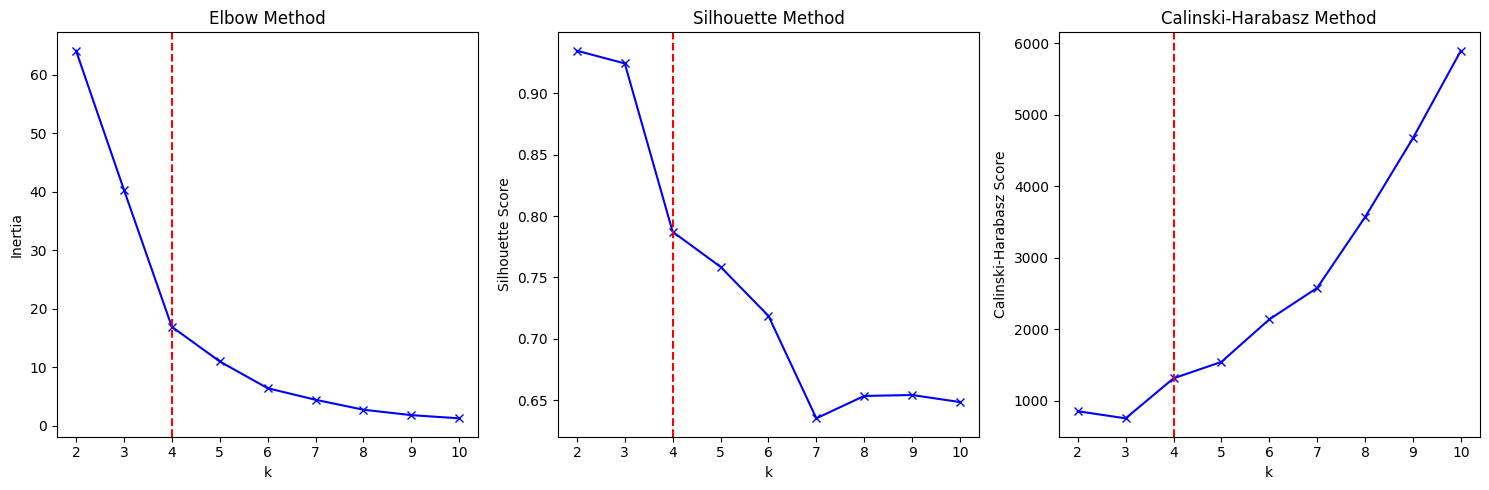

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fbe5401ad40>
Traceback (most recent call last):
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/local_disk0/.ephemeral_nfs/envs/pythonEnv-71b3d414-da85-475f-bc1b-292d4a917618/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/local_disk0/.ephemeral_nfs/envs/pyt

Optimal number of clusters: 4


In [0]:
# create a table that contains partner_ids and their cluster ranks
# I'm using k-means since it aligns with reality well. You can try other methods if you want. Just change the argument to the 'method' keyword below
df_clustered, summary = cluster_and_rank(data, method='kmeans')


In [0]:
# Create and display the partner rank table
partner_rank_table = create_partner_rank_table(df_clustered, summary)
print("\nPartner Rank Table:")
print(partner_rank_table)


Partner Rank Table:
    partner_id  cluster_rank
21         718           1.0
105          1           2.0
61        1442           2.0
233        463           2.0
77         475           2.0
..         ...           ...
268          9           4.0
221        902           4.0
190        924           4.0
101        955           4.0
219        987           4.0

[269 rows x 2 columns]


In [0]:
# write this table to dev.general
# Convert pandas DataFrame to Spark DataFrame
partner_rank_spark_df = spark.createDataFrame(partner_rank_table)

partner_rank_spark_df.createOrReplaceTempView("partner_rank_view")

In [0]:
# Write to SQL table
partner_rank_spark_df.write \
    .mode("overwrite") \
    .saveAsTable("dev.bi.s12n_partner_cluster_ranks_mgtv")

In [0]:
%sql
select cluster_rank,count(*) as cnt from partner_rank_view group by 1 order by 1

cluster_rank,cnt
1.0,1
2.0,5
3.0,24
4.0,239
